In [7]:
%matplotlib inline
from ipywidgets import *
import numpy as np
import k3d
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [8]:
from scipy.integrate import solve_ivp

In [9]:
class ThinLens(ABCD):
    def __init__(self, f):
        self.f = f
        m = np.identity(4, dtype=np.float64)
        m[2,0] = -1./f
        m[3,1] = -1./f
        self.m = m
        
class CurvedMirror(ABCD):
    def __init__(self, R):
        self.R = R
        m = np.identity(4, dtype=np.float64)
        m[2,0] = -2./R
        m[3,1] = -2./R
        self.m = m

In [10]:
Prop(10).m

array([[ 1.,  0., 10.,  0.],
       [ 0.,  1.,  0., 10.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

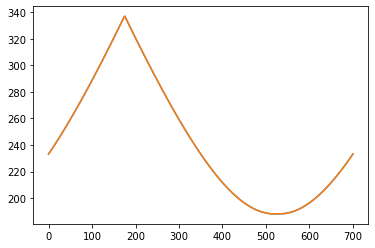

w_cav = 233.145 um


In [40]:
dprop = 350
Rmirr = 500#dprop/2+0.5

elemets = [Prop(dprop*0.5), CurvedMirror(Rmirr), Prop(dprop), CurvedMirror(10000),Prop(dprop*0.5)]
abcd_cav = ABCDSystem(elemets, wl=480e-6)
x = np.linspace(0, 2*dprop, 500)
ws = abcd_cav.compute_waists(x)
plt.figure()
plt.plot(x, ws*1e3)
plt.show()
print(f'w_cav = {ws[0][0]*1e3:.3f} um')

In [19]:
Rmirr

175.1

In [35]:
def blue_cavity(eps = 0.0, dprop = 350.0, Rmirr = 180.0):
    return [Prop(dprop*0.5), CurvedMirror(10000.0), Prop(dprop), CurvedMirror(Rmirr),Prop(dprop*0.5)]

In [36]:
def _waists_vs_param(cavfct, parname, scanrange, N=300, degmodenum=1, s=3, plot=True):
    stab = lambda m: abs(0.5*np.trace(m))<1
    La = inspect.signature(cavfct).parameters[parname].default
    if isinstance(scanrange, tuple):
        Las = np.linspace(scanrange[0], scanrange[1], N)
    else:
        Las = La + np.linspace(-scanrange*La, scanrange*La, N)
    ms = np.zeros((N))
    ws = np.zeros((N,2))
    freqs = np.zeros((N,4))
    for i, l in enumerate(Las):
        pardct = {parname: l}
        try:
            system = ABCDSystem(cavfct(**pardct))
            w = system.waist_at(0)
            #if abs(w[0])*1e3 > 10:
            #    w = w*np.nan
        except:
            ws[i,:] = np.nan
            ms[i] = np.nan
            freqs[i,...] = np.nan
        else:
            ms[i] = stab(system.abcd_rt)
            ws[i,:] = np.sort(w)
            freqs[i,...] = np.concatenate(system.get_freqs(s=s))

    # find the degeneracy condition: smallest s-fold transverse mode splitting with a stable mode
    degIdx=1+degmodenum
    #stable_mode_mask = [all(wpair>0) for wpair in ws]
    #subset_idx = np.argmin(np.abs(freqs[:,degIdx][stable_mode_mask]))
    #idx = np.arange(np.abs(freqs[:,degIdx]).shape[0])[stable_mode_mask][subset_idx] 
    idx = np.argmin(np.abs(freqs[:,degIdx]))
    if plot:
        g, ax = plt.subplots(ncols=2, figsize=(8,4))
        ax[0].plot(Las, ws*1e3)
        ax[0].set_ylabel('waist [um]')
        ax[1].plot(Las, freqs*1e-6)
        ax[1].set_ylabel('MHz')
        #ax[1].axhline(0, color='grey')
        #ax[0].axvline(Las[idx], color='grey')
        #ax[1].axvline(Las[idx], color='grey')
        #plt.show()
        Ldeg = Las[idx]
        return Ldeg, ax
    else:
        return Las, ws

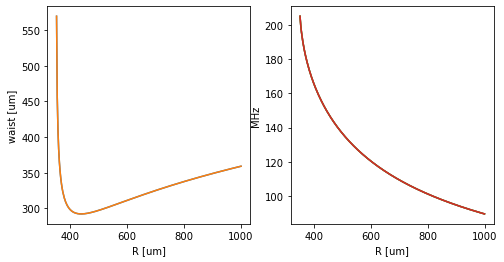

In [39]:
_, ax = _waists_vs_param(blue_cavity, 'Rmirr', (260, 1000), s=1)
ax[0].set_xlabel('R [um]')
ax[1].set_xlabel('R [um]')
plt.show()

## Mode matching

In [21]:
elemets = grin_cavity_3(eps=-20*1e-3, dprop=100.0)
abcd_cav = ABCDSystem(elemets)
x = np.linspace(0, abcd_cav.Ltot*1.005, 5000)
#x = np.linspace(0, 10, 500)
ws = abcd_cav.compute_waists(x)
# ws_ref = abcd_ref.compute_waists(x)
plt.figure()
plt.plot(x, ws*1e3)
# plt.plot(x, ws_ref*1e3)
plt.show()
print(f'w_cav = {ws[0][0]*1e3:.3f} um, w_ref = {ws_ref[0][0]*1e3:.3f} um')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

w_cav = 1.875 um, w_ref = 590.812 um


In [23]:
q_w = abcd_cav.q_at(0.0)

In [67]:
d_im = 11 #10-2 #11.0
f_im = 11#11.0 
elemets_im = [Prop(d_im), ThinLens(f_im), Prop(300.0), ThinLens(500.0), Prop(500)]
# elemets_im = [Prop(d_im), ThinLens(f_im), Prop(100.0), ThinLens(-50.0), Prop(40), ThinLens(200.0), Prop(200) ]
abcd_im = ABCDSystem(elemets_im)

x_im = np.linspace(0, abcd_im.Ltot+20, 1000)
ws_im = abcd_im.compute_waists(x_im, qin=q_w)
plt.figure()
plt.plot(x_im, ws_im)
plt.axhline(0.5)
plt.xlabel("propagation distance [mm]")
plt.ylabel("beam size (radius) [mm]")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
plt.close()

In [115]:
ng = 1.517 # fused silica 1.4537
d_mirr = 4.0
#C240TMD-B (EFL 8.0mm)
nl = 1.517 # BK7  
# d_lens = 3.43
# R_lens = 4.638124 #(https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3811)

#C220TMD-B (EFL 11.0mm)
# nl = 1.517 # BK7  
# d_lens = 5.0
# R_lens = 6.428132 #(https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3811)

# LA4647-B
d_lens = 4.3
R_lens = 9.2 #https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=6532&pn=LA4647-B#6533 

d_im = 20.0-d_mirr #8.35-1.1-1 #8.35#from mirror back face to end of small optics adapter

elemets_im = [ABCD(Glass(n2=ng).m), Prop(d_mirr, n=ng), ABCD(Glass(n1=ng).m), Prop(d_im),\
                ABCD(Glass(n2=ng).m), Prop(d_lens, n=ng),  ABCD(CurvedGlass(R=-R_lens, curv='CC', n1=ng).m),\
                   Prop(50.0)]
abcd_im = ABCDSystem(elemets_im)

In [ ]:
x_im = np.linspace(0, abcd_im.Ltot, 500)
ws_im = abcd_im.compute_waists(x_im, qin=q_w)
plt.figure()
plt.plot(x_im, ws_im)
plt.axhline(6.0)
plt.show()

In [106]:
q_in = abcd_cav.q_at(abcd_cav.Ltot/2) 

In [46]:
d_mm = 10.0-2
f_mm = 11.0 
elemets_mm = [Prop(d_mm), ThinLens(f_mm), Prop(100.0)]
abcd_mm = ABCDSystem(elemets_mm)